# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 6th
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you Python.
- Do not use any code from Nengo

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

Use method for computing decoders for this whole assignment.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>
</ol>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy


def calc_rms(x):
    return np.sqrt(np.mean(np.power(x,2)))


In [25]:
class LIFNeuron2:
    
    def __init__(self, enc=1, tau_ref=0.002, tau_rc=0.02, min_rate=100, max_rate=200, alpha=None, j_bias=None):
        self.x_int = np.random.uniform(-2,2)
        self.min_rate = min_rate
        self.max_rate = max_rate
        self.enc = enc
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        self.encoder = np.random.choice([1,-1])
        if alpha is None and j_bias is None:
            self.j_bias = 1/(1-np.exp((self.tau_ref-(1/self.min_rate))/self.tau_rc))
            self.alpha = 1/(1-np.exp((self.tau_ref-(1/self.max_rate))/self.tau_rc))-self.j_bias
        else: 
            self.j_bias = j_bias
            self.alpha = alpha
    
            
    def get_spikes(self, x, dt):
        
        number_of_spikes = 0
        spikes = []
        v,i = 0,0
        while i < len(x):
            J = self.alpha*x[i]*self.enc + self.j_bias
            if v >= 1:
                v = 1.5
                number_of_spikes +=1
                if len(spikes) < len(x): spikes.append(v)
                v,j = 0,0
                while(j<self.tau_ref/dt):
                    i,j=i+1,j+1
                    if len(spikes) < len(x): spikes.append(v)
                v = v + dt*(1/self.tau_rc)*(J - v)
                i += 1        
                continue
            elif v < 0:
                v = 0
                if len(spikes) < len(x): spikes.append(v)
            else:    
                if len(spikes) < len(x): spikes.append(0)
           
            v = v + dt*(1/self.tau_rc)*(J - v)
            i += 1        
        return number_of_spikes, spikes
    
    def get_rates(self, x):
        
        firing_rate = np.random.uniform(self.min_rate, self.max_rate)
        J_max = 1/(1 - np.exp((self.tau_ref - 1/firing_rate)/self.tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int
        
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates

In [26]:
class LIFNeuron:
    e_vals = [-1,1]

    def __init__(self, tau_ref=0.002, tau_rc=0.02):
        self.x_int = np.random.uniform(-2,2)
        self.max_fire_rate = np.random.uniform(100,200)
        self.encoder = np.random.choice(self.e_vals)
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        J_max = 1/(1 - np.exp((tau_ref - 1/self.max_fire_rate)/tau_rc))
        self.alpha = (J_max - 1)/(2 - self.encoder*self.x_int)
        self.j_bias = 1 - self.alpha*self.encoder*self.x_int

    def set_vars(self, enc, alpha, j_bias):
        self.encoder = enc
        self.alpha = alpha
        self.j_bias = j_bias
    
    def print_vars(self):
        print(self.__dict__)

    def get_rates(self, x):
        rates = []
        for pos in x:
            rate = 0
            J = self.alpha*pos*self.encoder+self.j_bias
            if J > 1:
                rate = 1/(self.tau_ref - self.tau_rc*np.log(1 - 1/J))
            rates.append(rate)
        return rates
    
    def get_spikes(self, x, dt):
        '''Calculate voltage spikes for time-variant stimuli'''
        
        num_ref_steps = np.floor(self.tau_ref/dt)
        ref_count = 0
        spike_count = 0
        voltages = []
        spikes = []
        v = 0
        v_next = 0
        for stim in x:
            J = self.alpha*stim*self.encoder + self.j_bias
            if ref_count > 0:
                v = 0
                ref_count -= 1
            elif v >= 1: #spike
                v = 1.5 #constant spike voltage
                ref_count = num_ref_steps
                spike_count +=1
            elif v < 0: #keep positive
                v = 0
            
            if v == 1.5:
                spikes.append(1)
            else:
                spikes.append(0)
                
            v_next = v + dt*(1/self.tau_rc)*(J - v)
            voltages.append(v)
            v = v_next
        
        return  spike_count, spikes


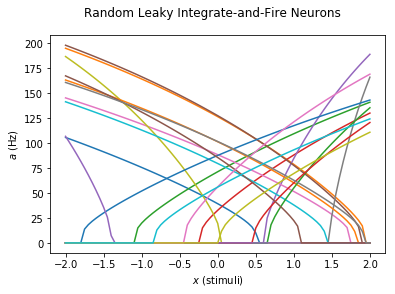

In [3]:
dt = 0.001


def generate_LIF_neurons(num, stimuli):
    neurons = []
    rates = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
        s = n.get_rates(stimuli)
        rates.append(s)
    return neurons, rates


plt.figure()
plt.suptitle('Random Leaky Integrate-and-Fire Neurons')

num_neurons = 20
number_of_samples = 81 # samples
x = np.linspace(-2,2,number_of_samples)
neurons, rates = generate_LIF_neurons(num_neurons, x)
for neuron, nrate in zip(neurons, rates):
    plt.plot(x, nrate)

plt.xlabel('$x$ (stimuli)')
plt.ylabel('$a$ (Hz)')
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li> [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise ($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).</li>
</ol>

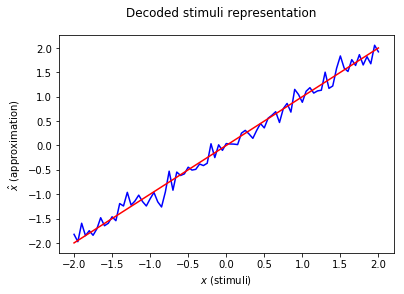

In [4]:
A = np.transpose(rates)
stddev_noise = 0.1*200

gamma_noisy = np.dot(np.transpose(A),A)/number_of_samples + np.power(stddev_noise,2)*np.identity(A.shape[1])
upsilon = np.dot(np.transpose(A),x)/number_of_samples
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

gauss_noise = np.random.normal(scale=stddev_noise,size=np.shape(A))
x_approx = np.dot(A + gauss_noise,decoders)

plt.figure()
plt.suptitle('Decoded stimuli representation')
plt.plot(x,x_approx,'b')
plt.plot(x,x,'r')
plt.xlabel('$x$ (stimuli)')
plt.ylabel(r'$\hat x$ (approximation)')
plt.show()

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t/\tau} dt$</li>
</ol>

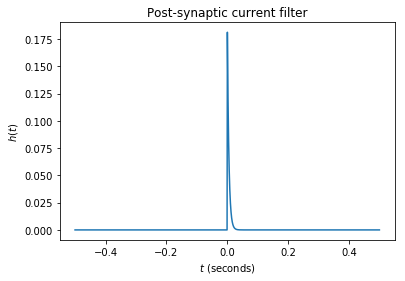

In [11]:
def generate_ht(t, n, tau):
    h = t**n * np.exp(-t/tau)
    h[np.where(t<0)]=0
    h = h/np.linalg.norm(h,1)
    return h


def generate_signal(T, dt, rms, limit, seed=0):
    
    np.random.seed(seed=seed)
    
    number_of_samples = int(T/dt)
    frequencies=np.arange(number_of_samples)/T - number_of_samples/(2*T)
    X = np.zeros(len(frequencies)).tolist()
    
    for i, f in enumerate(frequencies):
        if abs(f) <= limit:
            real, imag = np.random.normal(), np.random.normal()*1j
            X[i] = real + imag
            if f < 0: X[i] = real - imag
       
    x =np.fft.ifft(np.fft.ifftshift(X)).real
    x_rms = np.sqrt(np.mean(np.power(x,2)))
    x = [val*rms/(x_rms) for val in x]
    X = np.fft.fftshift(numpy.fft.fft(x))   
    return x,X




index_of_x_zero = np.where(x==0)[0][0]

neuron_20_50 = None
for i in range(len(A[index_of_x_zero])):
    val = A[index_of_x_zero][i]
    if val>=20 and val<=50:
        neuron_20_50 = neurons[i]
        break
        
neuron_1 = LIFNeuron(alpha=neuron_20_50.alpha, j_bias=neuron_20_50.j_bias, enc=1)
neuron_2 = LIFNeuron(alpha=neuron_20_50.alpha, j_bias=neuron_20_50.j_bias, enc=-1)

T, rms, dt, limit = 1, 1, 0.001, 5
t = np.arange(0,T,dt)
sig, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit)



spikes = []
_, s = neuron_1.get_spikes(sig,dt)
spikes.append(s)
_, s = neuron_2.get_spikes(sig,dt)
spikes.append(s)


tau = 0.005
t = np.arange(1000)*dt - 0.5
# t = np.linspace(0, 2, 1000)
h = generate_ht(t, 0, tau)

plt.title('Post-synaptic current filter')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$h(t)$')
plt.plot(t,h)
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph</li>
</ol>

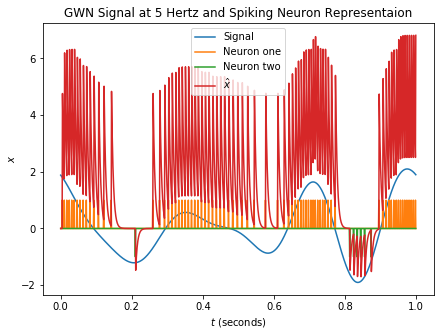

In [30]:
plt.figure(figsize=(7,5))
plt.plot(t,sig,label='Signal')
plt.title('GWN Signal at %d Hertz and Spiking Neuron Representaion' % limit)
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
pos_spikes = spikes[0]
neg_spikes = [-1*spike for spike in spikes[1]]
plt.plot(t,pos_spikes,label='Neuron one')
plt.plot(t,neg_spikes,label='Neuron two')


rates = []
rates.append(neuron_1.get_rates(sig))
rates.append(neuron_2.get_rates(sig))

As = np.transpose(rates)

stddev_noise = 0.1*200
gamma_noisy = np.dot(np.transpose(As),As)/number_of_samples + np.power(stddev_noise,2)*np.identity(As.shape[1])
upsilon = np.dot(np.transpose(As),sig)/number_of_samples
decoders = np.dot(np.linalg.inv(gamma_noisy),upsilon)

fspikes1 = np.convolve(spikes[0], h, mode='same')
fspikes2 = np.convolve(spikes[1], h, mode='same')

As = np.array([fspikes1, fspikes2]).T
xhat = np.dot(As/dt,decoders)
plt.plot(t,xhat, label='$\hat{x}$')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Compute the RMSE of the decoding</li>
</ol>

In [13]:
print('RMSE: %s' % np.sqrt(np.mean(np.power(sig - xhat,2))))

RMSE: 2.148979468127253


## 3) Decoding from many neurons

Repeat question 2, but with more neurons.  Instead of picking particular neurons, randomly generate them with x-intercepts uniformly distributed between -2 and 2 and with maximum firing rates between 100 and 200 Hz.  Randomly choose encoder values to be either -1 or +1.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[2 marks] Plot Root Mean-Squared Error as the number of neurons increases, on a log plot.  Try 8 neurons, 16 neurons, 32, 64, 128, up to 256.  For the RMSE for a particular number of neurons, average over at least 5 randomly generated groups of neurons.  For each group of neurons, randomly generate the signal $x(t)$.  Use the same parameters as in question 2. Note: the RMSE should go down as the number of neurons increases</li>
</ol>

In [28]:
def generate_LIF_neurons(num):
    neurons = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
    return neurons

num_runs = 5
num_neurons = [8,16,32,64,128,256]
T, rms, dt, limit = 1, 1, 0.001, 5
rmse_vals = []

for n in num_neurons:
    neurons = generate_LIF_neurons(n)
    rmse_avg = 0
    for run in range(num_runs):
        signal, X = generate_signal(T=T,rms=rms,dt=dt,limit=limit)
        
        # Get rate decoders for neurons
        rates = []
        spikes = []
        for neuron in neurons:
            rates.append(neuron.get_rates(signal))
            _, s = neuron.get_spikes(signal,dt)
            spikes.append(s)

        rates = np.transpose(rates)
        stddev_noise = 0.1*200
        
#         d = generate_decoders(rates, signal, dt, stddev_noise)
        
        gam = np.dot(np.transpose(rates),rates)/number_of_samples \
                        + np.power(stddev_noise,2)*np.identity(rates.shape[1])
        ups = np.dot(np.transpose(rates),signal)/number_of_samples
        d = np.dot(np.linalg.inv(gam),ups)
        
        fspikes = [np.convolve(spike, h, mode='same') for spike in spikes]
        A = np.array(fspikes).T
        xhat = np.dot(A/dt,d)
        
        rmse_avg += np.sqrt(np.mean(np.power(signal - xhat,2)))
    rmse_vals.append(rmse_avg/num_runs)

print('RMSE')
for val in rmse_vals:
    print(val)

RMSE
0.7143017833404554
0.40668474069068045
0.30826018669787114
0.23599779351011807
0.21080598856556737
0.19872260659911567


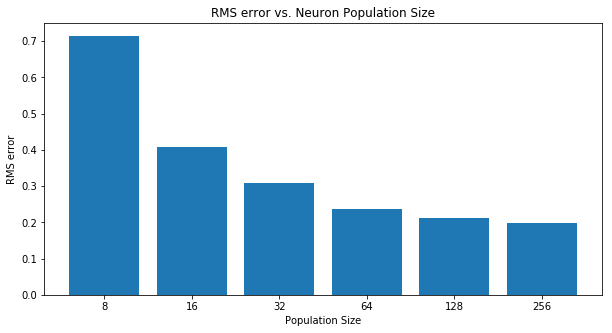

In [29]:
plt.figure(figsize=(10,5))
plt.bar(np.log2(num_neurons),rmse_vals , tick_label=num_neurons)
plt.title("RMS error vs. Neuron Population Size")
plt.xlabel("Population Size")
plt.ylabel("RMS error")
plt.show();

## 4) Connecting two groups of neurons

For this question, use two groups of neurons with intercepts between [-1, 1] to compute $y = 2x+1$.  The first group of neurons will represent $x$ and the second group will represent $y$.

Start by computing decoders.  You will need two decoders: one to decode $f(x)=2x+1$ from the first population, and one to decode $f(y)=y$ (the standard representational decoder) from the second population.  Remember that $\Upsilon$ can change depending on what function you want to decode.

Use the same neuron parameters as for previous questions, and use 200 randomly generated neurons in each population.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Show the behaviour of the system with an input of $x(t)=t-1$ for 1 second (a linear ramp from -1 to 0).  Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.</li>
<ul>
<li>Note that you should use the decoders that work for any input over the range of intercepts: do not re-compute decoders for any particular input (i.e. set of $x$ values).</li>
<li>Input $x(t)$ into the first group of neurons and produce spikes.  Decode from those spikes using the decoder for $f(x)=2x+1$.  Input that decoded result into the second group of neurons to produce spikes.  Use the second decoder ($f(y)=y$) to decode $\hat{y}(t)$.</li>
</ul>

In [35]:
def generate_LIF_neurons(num):
    neurons = []
    for i in range(num):
        n = LIFNeuron()
        neurons.append(n)
    return neurons

num_neurons = 200
t = np.arange(0,T,dt)
stddev_noise = 0.1*200

pop_one = generate_LIF_neurons(200)
pop_two = generate_LIF_neurons(200)

sig_one = np.linspace(-2,2,len(t))
sig_two = [2*k+1 for k in sig_one]

S= number_of_samples

# Get rate decoders for neuron population one
rates_one = []
for neuron in pop_one:
    rates_one.append(neuron.get_rates(sig_one))
    
r_one = np.transpose(rates_one)
gam = np.dot(np.transpose(r_one),r_one)/S \
                + np.power(stddev_noise,2)*np.identity(r_one.shape[1])
ups = np.dot(np.transpose(r_one),sig_two)/S
d_one = np.dot(np.linalg.inv(gam),ups)

# Get rate decoders for neuron population two
rates_two = []
for neuron in pop_two:
    rates_two.append(neuron.get_rates(sig_one))

r_two = np.transpose(rates_two)
gam = np.dot(np.transpose(r_two),r_two)/S \
                + np.power(stddev_noise,2)*np.identity(r_two.shape[1])
ups = np.dot(np.transpose(r_two),sig_one)/S
d_two = np.dot(np.linalg.inv(gam),ups)

# Show behaviour of system
x = np.linspace(-1,0,len(t))
y = [2*k+1 for k in x]



spikes_one = []
for neuron in pop_one:
    _, s = neuron.get_spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.dot(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    _, s = neuron.get_spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.dot(A/dt,d_two)




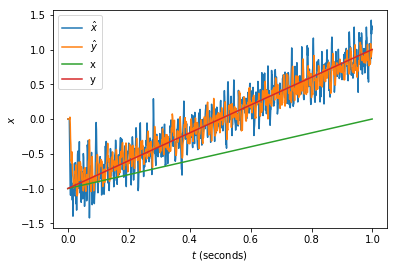

In [40]:
plt.plot(t,xhat,label='$\hat{x}$')
plt.plot(t,yhat,label='$\hat{y}$')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.legend()
plt.show()

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)</li>
</ol>

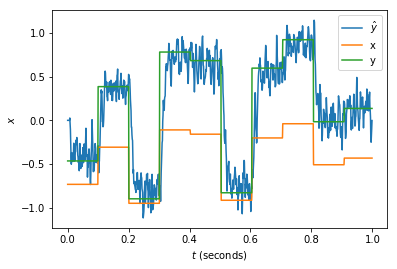

In [43]:
x = []
num = np.random.uniform(-1,0)
count = 0
for time in t:
    if count >= 100:
        num = np.random.uniform(-1,0)
        count = 0
    else:
        count += 1
    x.append(num)

y = [2*k+1 for k in x]

spikes_one = []
for neuron in pop_one:
    _, s = neuron.get_spikes(x,dt)
    spikes_one.append(s)

fspikes_one = [np.convolve(s, h, mode='same') for s in spikes_one]
A = np.array(fspikes_one).T
xhat = np.dot(A/dt,d_one)

spikes_two = []
for neuron in pop_two:
    _, s = neuron.get_spikes(xhat,dt)
    spikes_two.append(s)

fspikes_two = [np.convolve(s, h, mode='same') for s in spikes_two]
A = np.array(fspikes_two).T
yhat = np.dot(A/dt,d_two)

plt.plot(t,yhat,label='$\hat{y}$')
plt.plot(t,x,label='x')
plt.plot(t,y,label='y')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.legend()
plt.show()